*Contexto*

Junto con el departamento de marketing de una gran tienda en línea se han recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. Para determinar que prueba priorizar se recurrirá a los frameworks ICE y RICE. Posteriormente, se analizarán los resultados de la prueba de hipótesis.

/datasets/hypotheses_us.csv

- *Hypotheses* — breves descripciones de las hipótesis
- *Reach* — alcance del usuario, en una escala del uno a diez
- *Impact* — impacto en los usuarios, en una escala del uno al diez
- *Confidence* — confianza en la hipótesis, en una escala del uno al diez
- *Effort* — los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort , más recursos requiere la prueba.

/datasets/orders_us.csv

- *transactionId* — identificador del pedido
- *visitorId* — identificador del usuario que realizó el pedido
- *date* — fecha del pedido
- *revenue* — ingresos del pedido
- *group* — el grupo del test A/B al que pertenece el usuario

/datasets/visits_us.cs

- 

*Indice de contenidos*

1. [Inicialización: Importar librerías](#1.-Inicialización:-Importar-librerías)
2. [Cargar los datos: lectura de los archivos csv](#2.-Cargar-los-datos:-lectura-de-los-archivos-csv)
3. [Descripción de los datos](#3.-Descripción-de-los-datos)
5. [Preprocesamiento de datos](#4-preprocesamiento-de-datos)
5. [Priorización de hipótesis](#5-priorización-de-hipótesis)
6. [Análisis del Test A/B](#6-análisis-del-test-ab)
7. [Conclusiones](#7.-Conclusiones)

# 1. Inicialización: Importar librerías 

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
from matplotlib import pyplot as plt

# 2. Cargar los datos: lectura de los archivos csv

Los datos provienen de tres dataframes que se cargan a continuación:

- Hypotheses: contiene registros sobre las hipótesis formulados según el enfoque RICE
- Orders: es un archivo con todos los pedidos del período.
- Visits: es un archivo que continene el número de visitas específicadas por día para el grupo de test A/B

In [3]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

# 3.Descripción de los datos

Se usarán los métodos info() y head(), lo que entregará un resumen de cada dataframe, y dará luz sobre qué tipo de correcciones pueden hacerse en ellos de forma inicial.

In [4]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes


In [5]:
hypotheses.head()

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. T...
1,Launch your own delivery service. This will sh...
2,Add product recommendation blocks to the store...
3,Change the category structure. This will incre...
4,Change the background color on the main page. ...


Al imprimir una muestra del dataframe, se observa que hay que añadir el parámetro de sep para leer el dataframe correctamente. No hay datos nulos. Además, se cambiarán a minúscula los nombres de las columnas

In [6]:
import pandas as pd

hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
hypotheses = hypotheses.rename(columns={
    'Hypothesis': 'hypothesis',
    'Reach': 'reach',
    'Impact': 'impact',
    'Confidence': 'confidence',
    'Effort': 'effort'
})

Se comprueba si los cambios han sido aplicados imprimiendo una muestra del dataframe.

In [7]:
hypotheses.head()

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


Se observan 5 columnas sin datos nulos. Se cambiará los nombres de las columnas transactionID y visitorID. Además, se cambiará el tipo de datos para la columnas date a datetime.

In [9]:
orders = pd.read_csv('/datasets/orders_us.csv', 
                     parse_dates=['date'])

orders = orders.rename(columns={
    'transactionId': 'transaction_id',
    'visitorId': 'visitor_id',
})

Se comprueba si los cambios han sido aplicados imprimiendo una muestra del dataframe.

In [10]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [12]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


El dataframe cuenta con tres columnas en las que no se observan datos nulos. Los nombres de las columnas son correctos, y solo se corregirá el tipo de datos en la columna date.

In [13]:
visits['date'] = pd.to_datetime(visits['date'])

# 4. Preprocesamiento de datos

Uno de los errores frecuentes a la hora de realizar pruebas A/B es no dividir el tráfico de forma correcta y adecuada. A continuación, se verificará si existen usuarios en ambos grupos. Lo que distingue a cada usuario es su id de visitante, por lo que en primer lugar se verificará que no hayan duplicados para los grupos A y B. Luego, se comprobará si existen usuarios con el mismo id en ambos grupos.

In [14]:
user_id_a = orders[orders['group'] == 'A']['visitor_id'].drop_duplicates()
user_id_b = orders[orders['group'] == 'B']['visitor_id'].drop_duplicates()

repeated_users = user_id_b[user_id_b.isin(user_id_a)]

print('Cantidad de usuarios que aparecen en ambos grupos:', len(repeated_users))

Cantidad de usuarios que aparecen en ambos grupos: 58


Se observa que 58 usuarios aparecen en ambos grupos, por lo que se procederá a eliminarlos.

In [15]:
orders = orders[~orders['visitor_id'].isin(repeated_users)]

# 5. Priorización de hipótesis

La priorización de hipótesis se hace con el objetivo de reducir los costos a partir de distintos frameworks. En este caso, se trabajará con los enfoques ICE y RICE, observando las consecuencias de aplicar cada uno de ellos.

In [16]:
hypotheses['ICE'] = (
    hypotheses['impact']
    *hypotheses['confidence']
)/hypotheses['effort']

hypotheses['RICE'] = (
    hypotheses['reach']
    *hypotheses['impact']
    *hypotheses['confidence']
)/hypotheses['effort']

hypotheses.head()

,hypothesis,reach,impact,confidence,effort,ICE,RICE
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,40.0
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,4.0
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,56.0
3,Change the category structure. This will incre...,8,3,3,8,1.125000,9.0
4,Change the background color on the main page. ...,3,1,1,1,1.000000,3.0


Se ordenará el dataframe en orden descendente de prioridad.

In [17]:
sorted_by_ice = hypotheses[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)
sorted_by_ice

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


Las tres hipótesis a priorizar según el framework ICE son:
- a) La hipótesis 8: Launch a promotion that gives users discounts on their birthdays
- b) La hipótesis 0: Add two new channels for attracting traffic. This will bring 30% more users
- c) La hipótesis 7: Add a subscription form to all the main pages. This will help you compile a mailing list

In [18]:
sorted_by_rice = hypotheses[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)
sorted_by_rice  

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


Las tres hipótesis a priorizar según el framework RICE son:
- a) La hipótesis 7: Add a subscription form to all the main pages. This will help you compile a mailing list
- b) La hipótesis 2: Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
- c) La hipótesis 0: Add two new channels for attracting traffic. This will bring 30% more users

Dos hipótesis aparecen con gran relevancia usando los enfoques de ICE y RICE: Las hipótesis 0 y 7. Sin embargo, dicustiendo con el departamento marketing, se decide proceder a la prueba A/B con la hipótesis 2, es decir, agregar recomendaciones de productos a la tienda. Se escogió esta hipótesis ya que impacta tanto la conversión como el tamaño medio de compra, y el objetivo de la tienda en estos momentos es aumentar los ingresos.

# 6. Análisis del Test A/B

## Ingreso acumulado por grupo

Para evitar caer en errores como el peeking problem, se usarán métricas acumuladas. En primer lugar, se calcularán los datos diarios acumulados sobre los pedidos. Luego, se obtendrán los datos diarios acumulados sobre los visitantes. Finalmente, se fusionará ambas tablas y se nombrarán sus columnas. Dicha información, servirá de base para crear gráficos de ingresos acumulados por días.

In [19]:
dates_groups = (
    orders[['date','group']]
    .drop_duplicates()
) 

dates_groups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [20]:
orders_aggregated = (
    dates_groups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 
          'group' : 'max', 
          'transaction_id' : pd.Series.nunique, 
          'visitor_id' : pd.Series.nunique, 
          'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group'])
)

orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [21]:
visitors_aggregated = (
    dates_groups
    .apply(lambda x: visits[(visits['date'] <= x['date']) & (visits['group'] == x['group'])]
           .agg({'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1)
    .reset_index(drop=True)
    .sort_values(by=['date', 'group'])
)

visitors_aggregated.head()

,date,group,visits
4,2019-08-01,A,719
5,2019-08-01,B,713
12,2019-08-02,A,1338
11,2019-08-02,B,1294
17,2019-08-03,A,1845


In [22]:
visitors_aggregated = (
    dates_groups
    .apply(lambda x: visits[(visits['date'] <= x['date']) & (visits['group'] == x['group'])]
           .agg({'date': 'max', 'group': 'max', 'visits': 'sum'}), axis=1)
    .reset_index(drop=True)
    .sort_values(by=['date', 'group'])
)

visitors_aggregated.head()

,date,group,visits
4,2019-08-01,A,719
5,2019-08-01,B,713
12,2019-08-02,A,1338
11,2019-08-02,B,1294
17,2019-08-03,A,1845


A continuación se fusionarán ambas tamblas con el método merge().

In [24]:
cumulative_data = (
    orders_aggregated
    .merge(visitors_aggregated, 
           left_on=['date', 'group'], 
           right_on=['date', 'group'])
)
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


A partir del dataframe cumulative_data, se pueden crear gráficos de ingresos acumulados por día y grupo.

Text(0.5, 1.0, 'Ingresos acumulados por días según grupo')

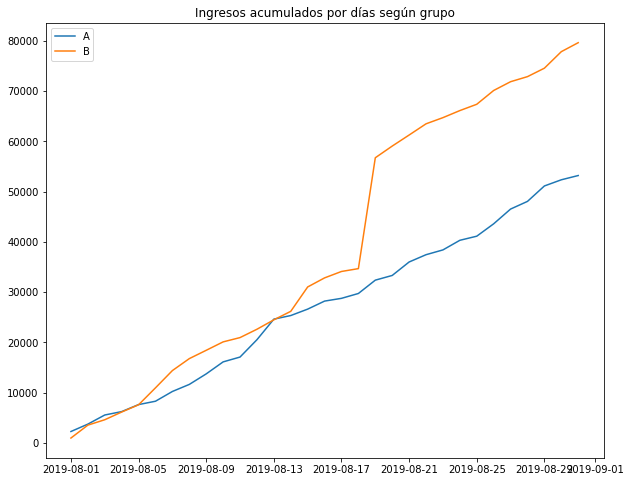

In [27]:
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10, 8))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.legend() 
plt.title('Ingresos acumulados por días según grupo')

Se observa que los ingresos aumentaron durante el periodo de la prueba A/B, lo cual es una buena señal. Sin embargo, hay un salto importante para el grupo B entre el 17 y el 21 de agosto, y será pertinente analizar más adelante si se está en presencia de valores atípicos. 

## Tamaño de pedido promedio acumulado por grupo

Para calcular el tamaño promedio de compra por grupo se dividirán los ingresos acumulados entre el número acumulado de pedidos.

Text(0.5, 1.0, 'Tamaño promedio de compra según grupo')

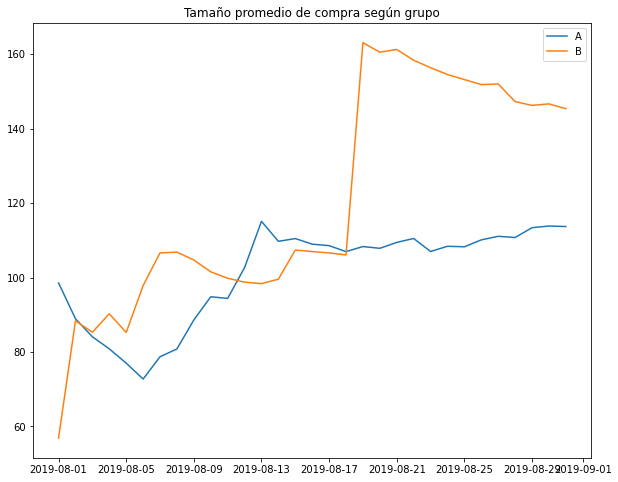

In [28]:
plt.figure(figsize=(10, 8))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend()
plt.title('Tamaño promedio de compra según grupo')

Nuevamente se observa un pico importante para el promedio de compras entre el 17 y el 21 de agosto. Además, para ambos grupos el tamaño promedio acumulado tendió al alza dentro del periodo analizado.

## Diferencia relativa en el tamaño de pedido promedio

Para visualizar la diferencia relativa para los promedio de compra se agregará un eje horizontal con el método axhline(). Además, es pertinente recordar que las diferencias relativas se calcula como la métrica acumulada del grupo B / métrica acumulada del grupo A - 1.

In [77]:
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_revenue.columns = ['date', 'revenue_a', 'orders_a', 'revenue_b', 'orders_b']

merged_cumulative_revenue.head()

,date,revenue_a,orders_a,revenue_b,orders_b
0,2019-08-01,2356.8,24,1620.0,21
1,2019-08-02,3860.3,44,4243.8,45
2,2019-08-03,5675.5,68,6050.6,61
3,2019-08-04,6822.1,84,7767.9,78
4,2019-08-05,8810.2,109,9262.9,101


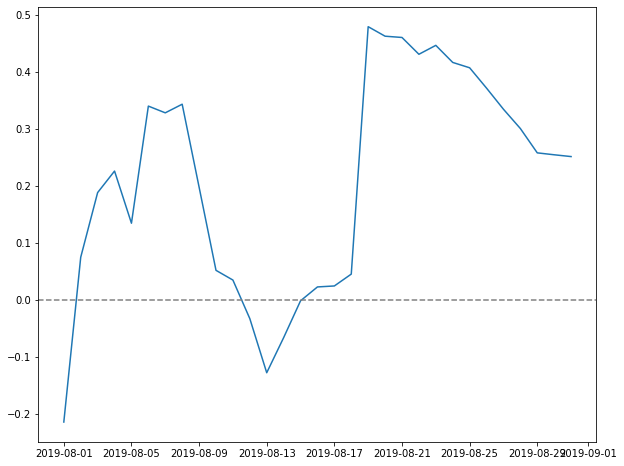

In [81]:
plt.figure(figsize=(10, 8))
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/(merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)

plt.axhline(y=0, color='grey', linestyle='--')
plt.title('Diferencia relatis por días según grupo')

Se ve una gran diferencia entre segmentos del gráfico, por lo que probablemente hay valores atípicos presentes.

## Tasa de conversión de cada grupo

Se calculará la tasa de conversión dividiendo la cantidad de pedidos por el número de visitantes. Para visualizar la tasa de conversión se reajustará la escala del gráfico utilizando el método plt.axis()

(18109.0, 18139.0, 0.0, 0.05)

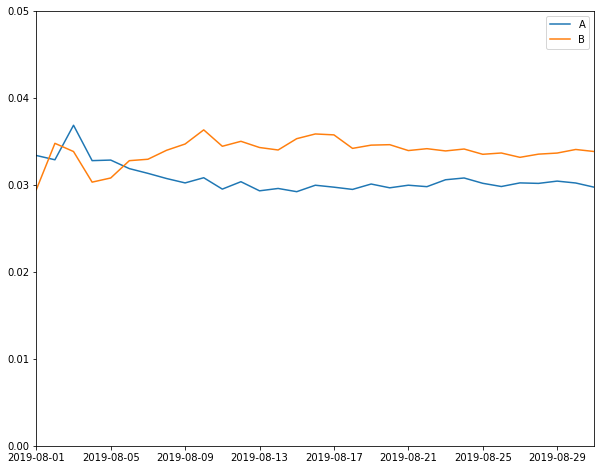

In [83]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(10, 8))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()

plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-08-31'), 0, 0.05])

<div class="alert alert-success">
<b>✔️ Comentario del revisor v2:</b> Genial!

El gráfico es bastante simétrico, lo que es sospechoso al tratarse de datos experimentales. De todas formas, se analizarán posibles anomalías más adelante a través del cálculo de percentiles.

## Gráfico de dispersión del número de pedidos por usuario

Usando el método groupby() se calculará cuántos pedidos hacen los usuarios. Dicha información será la base del gráfico de dispersión.

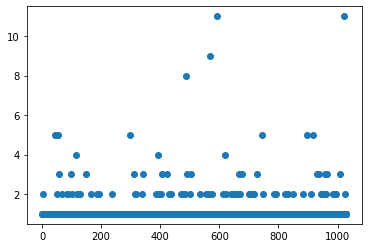

In [87]:
orders_by_users = (
    orders
    .drop(['group', 'revenue','date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users.columns = ['visitor_id', 'orders']

x_values = pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders']) 

El gráfico de dispersión muestra que la mayoría de los usuarios hace solo un pedido, y se ven datos aislados de usuarios con incluso más de 10 pedidos, lo que cual hace pesar aún más la sospecha de la presencia de datos anómalos.

## Cálculo de percentiles

Para definir en qué punto los datos se convierten en una anomalía se analizaran los percentiles 95 y 99.

In [88]:
print(np.percentile(orders_by_users['orders'], [95, 99])) 

[2. 4.]


El número de usuarios que realizó más de 2 pedidos no excede el cinco por ciento, por lo tanto, 2 pedidos por usuario puede ser tomado como el valor que define cuando un punto de datos se convierte en una anomalía.

## Gráfico de dispersión de los precios de los pedidos

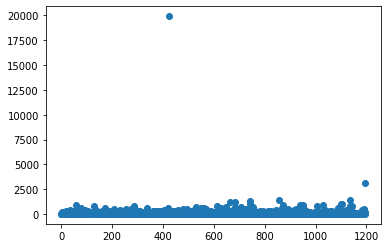

In [89]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

Se observan datos anómalos con pedidos que sobrepasan el rango de los 2500 dólares. Para observar de cerca este fenómeno, nuevamente se recurrirá al análisis de percentiles.

In [90]:
print(np.percentile(orders['revenue'], [95, 99]))

[435.54  900.904]


El número de pedidos que excede los 435.54 dólares no excede el 5%, por lo tanto, 435.54 dólares por pedidos puede ser tomado como el valor que define cuando un punto de datos sobre los ingresos generados por pedido se convierte en una anomalía dentro del dataframe.

## Significancia estadística de la diferencia en la conversión entre los grupos a partir de los datos en bruto

Para calcular la significancia estadística se recurrirá a la prueba no paramétrica U de Mann-Whitney. Las ventajas de las pruebas no paramétricas es que no asumen la normalidad de la distribución para operar, por lo que son útiles a la hora de estar en presencia de valores atípicos. Para aplicar la prueba, se necesita diferenciar ambas muestras: A y B, a partir de sus datos sobre conversión de clientes. Para comenzar, se calculará cuántos pedidos hacen los usuarios de cada grupo.

In [93]:
orders_by_users_a = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
orders_by_users_b.columns = ['visitor_id', 'orders']

In [96]:
sample_a = (
    pd.concat([orders_by_users_a['orders'],
               pd.Series(0, 
                         index=np.arange(
                             visits[visits['group']=='A']['visits'].sum() 
                             - len(orders_by_users_a['orders'])
                         ), 
                         name='orders')],
              axis=0
             )
)

In [97]:
sample_b = (
    pd.concat([orders_by_users_b['orders'],
               pd.Series(0, 
                         index=np.arange(
                             visits[visits['group']=='B']['visits'].sum() 
                             - len(orders_by_users_b['orders'])
                         ), 
                         name='orders')],
              axis=0
             )
)

Con las muestras ya construidas se procede a realizar la prueba U de Mann-Whitney utilizando el método st.mannwhitney() del paquete scipy. Se establece como nivel significancia estadística de un 95%, es decir, un valor de alpha de 0.05. 

In [98]:
alpha = 0.05
results = st.mannwhitneyu(sample_a, sample_b)
print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Se rechaza la hipótesis nula: la diferencia es estadísticamente significativa")
else:
    print("No se rechaza la hipótesis nula: no se pueden sacar conclusiones sobre la diferencia entre ambos grupos")

p-value:  0.016792355056752608
Se rechaza la hipótesis nula: la diferencia es estadísticamente significativa


El valor de p es menor a 0.05 por lo que se ha rechazado la hipótesis nula y se puede afirmar que, al menos con los datos en bruto, existe una diferencia en la tasa de conversión para los grupos A y B.

In [ ]:
## Significancia estadística de la diferencia en el tamaño promedio de compra a partir de los datos en bruto

Para calcular la significancia estadística en los ingresos que generan las compras, nuevamente se crearán las muestras para los grupos A y B y se aplicará la U de Mann-Whitney.

In [101]:
sample_a2 = orders[orders['group']=='A']['revenue']
sample_b2 = orders[orders['group']=='B']['revenue']

results2 = st.mannwhitneyu(sample_a2, sample_b2)
print('p-value: ', results2.pvalue)

if (results2.pvalue < alpha):
    print("Se rechaza la hipótesis nula: la diferencia es estadísticamente significativa")
else:
    print("No se rechaza la hipótesis nula: no se pueden sacar conclusiones sobre la diferencia entre ambos grupos") 

p-value:  0.6915246773264736
No se rechaza la hipótesis nula: no se pueden sacar conclusiones sobre la diferencia entre ambos grupos


Esta vez no se puedo rechazar la  hipótesis nula, por lo que no se pueden hacer conjeturas sobre posibles diferencias entre ambos grupos respecto al tamaño de compra. 

Previamente se encontraron diferencias en la conversión entre los grupos A y B utilizando como base los datos en brutos. Es hora de confirmar si dicha diferencia se mantiene usando los datos filtrados, es decir, removiendo las anomalías del dataframe. Las anomalías que se encontraron fueron usuarios con muchos pedidos cuando el percentil 95 estaba en dos pedidos por usuario, y usuarios que generaban muchos ingresos por pedido, superando los 435 dólares.

In [135]:
users_with_excess_orders_a = orders_by_users_a[orders_by_users_a['orders'] > 2]['user_id']
users_with_excess_orders_b = orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id']

users_with_excess_orders = pd.concat([users_with_excess_orders_a, users_with_excess_orders_b], axis=0)

print('Usuarios con más de dos pedidos en cualquiera de los grupos:', len(users_with_excess_orders), 'usuarios')

Usuarios con más de dos pedidos en cualquiera de los grupos: 24 usuarios


Hay 24 usuarios que presentan anomalías en su cantidad de pedidos. Ahora se calculará la cantidad de usuarios que han generado ingresos mayores a los esperados, para luego reunir ambos en la variable outliers.

In [113]:
users_with_excess_revenue = orders[orders['revenue'] > 435]['visitor_id']

print('Usuarios que generan un exceso de ingresos:',len(users_with_excess_revenue),'usuarios')

Usuarios que generan un exceso de ingresos 61 usuarios


Hay 61 usuarios que registran datos atípicos respecto a los ingresos que generán. A continuación se creará la variable outliers que guardará la información sobre estas anomalías.

In [115]:
outliers = pd.concat([users_with_excess_orders, users_with_excess_revenue], axis=0).drop_duplicates().sort_values()

In [ ]:
Ahora, se filtrarán dichos outliers de las muestras A y B que se habían calculado previamente. Para esto, se utilizará el método isin() buscando los id de usuario de aquellos que han sido identificado como usuarios anómalos.

In [122]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(outliers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group'] == 'A']['visits'].sum()
                - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [124]:
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(outliers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visits[visits['group'] == 'A']['visits'].sum()
                - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Con las muestras filtradas, se procede a realizar una vez más la prueba U de Mann-Whitney.

In [129]:
results_3 = st.mannwhitneyu(sample_a_filtered, sample_b_filtered)
print('p-value:', results_3.pvalue)

alpha = 0.05

if results_3.pvalue < alpha:
    print("Se rechaza la hipótesis nula: la diferencia es estadísticamente significativa")
else:
    print("No se rechaza la hipótesis nula: no se pueden sacar conclusiones sobre la diferencia entre ambos grupos")

p-value: 0.009158254749972094
Se rechaza la hipótesis nula: la diferencia es estadísticamente significativa


Aún filtrando los datos, se siguen observando diferencias estadísticamente significativas entre ambas pruebas. En base a todo el análisis realizado, se decide continuar la prueba por otro mes para obtener más datos.

# 7.Conclusiones

- El análisis comenzó con la importación de librerías y la carga de archivos. Los dataframes no mostraron datos ausentes pero se ajustaron los nombres de las columnas y los tipos de datos que contenían.
- El preprocesamiento de datos mostró la existencia de usuarios que aparecían en ambos grupos, por lo que fueron eliminados.
- A través de los enfoques ICE y RICE se seleccionaron las 6 hipótesis más relevantes, y se escogió la número 2 2, es decir, agregar recomendaciones de productos a la tienda, al ser aquella que impacta tanto la conversión como el tamaño medio de compra en un momento en que la empresa busca aumentar sus ingresos.
- El análisis del test A/B reveló la existencia de datos atípicos que fueron filtrados para verificar si existían diferencias estadísticamente significativas entre los grupos en relación a su tasa de conversión y tamaño promedio de compra. Efectivamente, se observaron diferencias para la tasa de conversión entre ambos grupos, donde a partir de los gráficos realizados se puede inferir que B es el grupo líder, sin embargo, para no sacar conclusiones apresuradas, se decidió continuar con el test A/B durante otro mes, para obtener más datos que puedan permitir un análisis más robusto.